In [326]:
# Imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [327]:
# Read GIS data
roads = gpd.read_file('data/GIS/2261_ulice_egib_wfs_gml.gml')
plots = gpd.read_file('data/GIS/2261_dzialki_egib_wfs_gml.gml')
buildings = gpd.read_file('data/GIS/2261_budynki_egib_wfs_gml.gml')

# Get our site geometry
site_gml_id = 'dzialki.490123'
site = plots[plots['gml_id'] == site_gml_id]
site.to_crs(epsg=2177)

,gml_id,coordinates,ID_DZIALKI,NUMER_DZIALKI,NAZWA_OBREBU,NUMER_OBREBU,NUMER_JEDNOSTKI,NAZWA_GMINY,GRUPA_REJESTROWA,DATA,geometry
55603,dzialki.490123,"6536098.100000,6023717.530000 6536155.140000,6...",226101_1.0049.222/4,222/4,Jasień,49,01_1,M.Gdańsk,7,2024-10-15 21:30:16,"POLYGON ((6536098.1 6023728.68, 6536108.37 602..."


In [328]:
site_geom = site.geometry.iloc[0]
neighbors = plots[plots.geometry.touches(site_geom)]
print("Site has", neighbors.shape[0], "neighboring plots")


Site has 10 neighboring plots


Site has access from 1 public road(s)
Park im. ks. Bronisława Kabata is the primary access road with the longest frontage
Site frontage length: 34.05m
Analysis radius: 102.15m


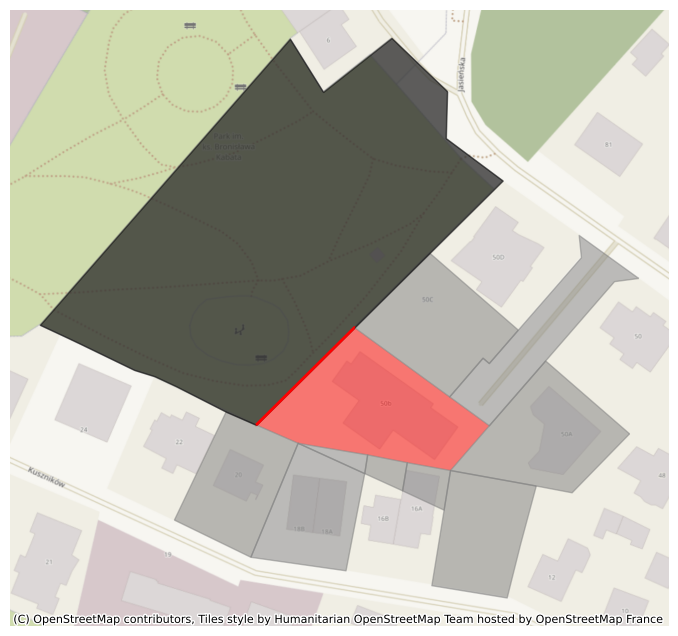

,gml_id_neighbor,coordinates_neighbor,ID_DZIALKI,NUMER_DZIALKI,NAZWA_OBREBU,NUMER_OBREBU,NUMER_JEDNOSTKI,NAZWA_GMINY,GRUPA_REJESTROWA,DATA,...,gml_id_road,coordinates_road,nazwa_gminy,id_gminy,nazwa_miejscowosci,id_miejscowosci,nazwa_ulicy,id_ulicy,data_uchwaly,nr_uchwaly
64195,dzialki.403950,"6536045.210000,6023728.680000 6536158.410000,6...",226101_1.0049.104,104,Jasień,49,01_1,M.Gdańsk,4,2024-10-15 21:30:16,...,ulice.80dc9338-9b50-4b89-a06d-2f10b51aa086,"6536004.980000,6023728.680000 6536156.510000,6...",Gdańsk,226101_1,Gdańsk,933016,Park im. ks. Bronisława Kabata,48641,2015-06-03 00:00:00,IX/193/15


In [329]:
# Find public road neighbors
public_neighbors = neighbors[neighbors['GRUPA_REJESTROWA'].isin([1, 4])]

# Find which public plots intersect with roads
public_road_neighbors = gpd.sjoin(public_neighbors, roads, how='inner', predicate='intersects', lsuffix='neighbor', rsuffix='road')
print("Site has access from", public_road_neighbors.shape[0], "public road(s)")

def get_road_side(plot_geom, road_geom, buffer_distance=0.1):
    """Get the road-facing side of a plot."""
    # Create a buffer around the road
    road_buffer = road_geom.buffer(buffer_distance)
    # Get the plot boundary
    plot_boundary = plot_geom.boundary
    # Find the intersection with the road buffer
    road_side = plot_boundary.intersection(road_buffer)
    return road_side

# Get road sides for each public road
site_road_sides = []
for idx, road in public_road_neighbors.iterrows():
    road_side = get_road_side(site_geom, road.geometry)
    if not road_side.is_empty:
        site_road_sides.append({
            'road_id': idx,
            'road_side': road_side,
            'road_name': road['nazwa_ulicy']
        })

# Find the primary road (with longest frontage)
road_lengths = [(info['road_id'], info['road_side'].length) for info in site_road_sides]
primary_road_id = max(road_lengths, key=lambda x: x[1])[0]
primary_road = public_road_neighbors.loc[primary_road_id]
primary_road_side = next(info['road_side'] for info in site_road_sides if info['road_id'] == primary_road_id)

# Calculate frontage length and analysis radius
primary_road_side_length = primary_road_side.length
analysis_radius = max(50, min(3 * primary_road_side_length, 200))

print(f"{primary_road['nazwa_ulicy']} is the primary access road with the longest frontage")
print(f"Site frontage length: {primary_road_side_length:.2f}m")
print(f"Analysis radius: {analysis_radius:.2f}m")

fig, ax = plt.subplots(figsize=(12, 8))
site.plot(ax=ax, color='red', alpha=0.5, label='Site')
neighbors.plot(ax=ax, color='gray', edgecolor='gray', alpha=0.5, label='Neighbors')
gpd.GeoSeries(primary_road.geometry).plot(ax=ax, color='black', edgecolor='black', alpha=0.5, label='Primary Road')
gpd.GeoSeries(primary_road_side).plot(ax=ax, color='red', linewidth=2, label='Primary Road Side')
ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.show()
public_road_neighbors

In [330]:
# Find built-up neighbors on the same road
buildings['centroid'] = buildings.centroid
building_centroids = buildings.set_geometry('centroid', inplace=False).set_crs(epsg=2177)

In [331]:
built_up_neighbors = gpd.sjoin(neighbors, building_centroids, how='inner', predicate='intersects', lsuffix='neighbors', rsuffix='building')
built_up_neighbors_on_the_same_road = built_up_neighbors[built_up_neighbors.geometry.touches(primary_road.geometry)]
number_of_built_up_neighbors_on_the_same_road = built_up_neighbors_on_the_same_road['gml_id_neighbors'].nunique()
print("Site has", number_of_built_up_neighbors_on_the_same_road, "built-up neighboring plots on the same access road")

Site has 2 built-up neighboring plots on the same access road


In [332]:
def get_setback(buildings, road_side):
    """Get the setback distance from a plot to a road."""
    setback = buildings.distance(road_side).min()
    return setback

if number_of_built_up_neighbors_on_the_same_road > 0:
    setbacks = []
    # Get unique neighbor plots
    unique_neighbors = built_up_neighbors_on_the_same_road.drop_duplicates(subset='gml_id_neighbors')
    
    for idx, plot in unique_neighbors.iterrows():
        # Get all buildings on this plot
        buildings_on_plot = buildings[buildings['gml_id'].isin(
            built_up_neighbors_on_the_same_road[
                built_up_neighbors_on_the_same_road['gml_id_neighbors'] == plot['gml_id_neighbors']
            ]['gml_id_building']
        )]
        
        
        if not buildings_on_plot.empty:
            # Get the road side for this plot
            road_side = get_road_side(plot.geometry, primary_road.geometry)
            
            # Calculate minimum setback for this plot
            setback = get_setback(buildings_on_plot.geometry, road_side)
            setbacks.append({
                'plot_id': plot['gml_id_neighbors'],
                'setback': setback
            })
        else:
            setbacks.append({
                'plot_id': plot['gml_id_neighbors'],
                'setback': 0
            })

    # Get the maximum setback from all neighbors
    max_setback = max(s['setback'] for s in setbacks)
    
    # Print individual setbacks for verification
    print("\nSetbacks by plot:")
    for s in setbacks:
        print(f"{s['plot_id']}: {s['setback']:.2f}m")
    print(f"\nRequired setback: {max_setback:.2f}m")
    
else:
    max_setback = 0
    print("No built-up neighbors on the same road, so no setback is required")


Setbacks by plot:
dzialki.361500: 5.11m
dzialki.282984: 8.06m

Required setback: 8.06m


In [333]:
# offset roadside to get setback line
primary_road = gpd.GeoSeries(primary_road.geometry)
primary_road.set_crs(epsg=2177, inplace=True)
setback_buffer = primary_road.buffer(max_setback)

site_and_neighbors = pd.concat([site, built_up_neighbors_on_the_same_road]).union_all()
setback = setback_buffer.intersection(site_and_neighbors)

/var/folders/j5/0qh0dgj5607fhs9231nrxjww0000gn/T/ipykernel_44894/2060024443.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


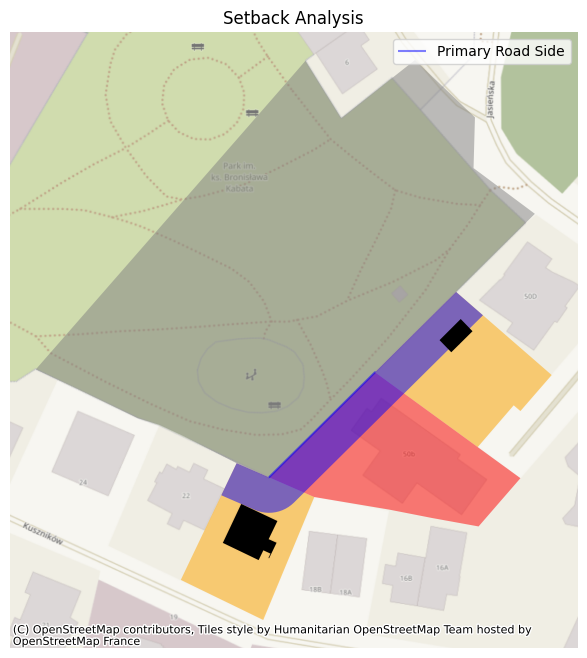

In [334]:
# Plot primary road, primary road side, site, built-up neighbors on the same road

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the primary road plot
gpd.GeoSeries(primary_road.geometry).plot(ax=ax, color='gray', alpha=0.5, label='Primary Road')

# Plot the built-up neighbors on the same road
built_up_neighbors_on_the_same_road.plot(ax=ax, color='orange', alpha=0.5, label='Built-up Plots on the Same Road')

# Plot the site
site.plot(ax=ax, color='red', alpha=0.5, label='Site')

# Plot the setback
setback.plot(ax=ax, color='blue', alpha=0.5, label='Setback')

# Plot the buildings on neighbors
buildings[buildings['gml_id'].isin(built_up_neighbors_on_the_same_road['gml_id_building'])].plot(ax=ax, color='black', label='Buildings on Plots')

# Plot the primary road side
gpd.GeoSeries(primary_road_side).plot(ax=ax, color='blue', alpha=0.5, label='Primary Road Side')

ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()

plt.title('Setback Analysis')
plt.legend()





Number of plots 92160
Analysis area has 42 built-up plots


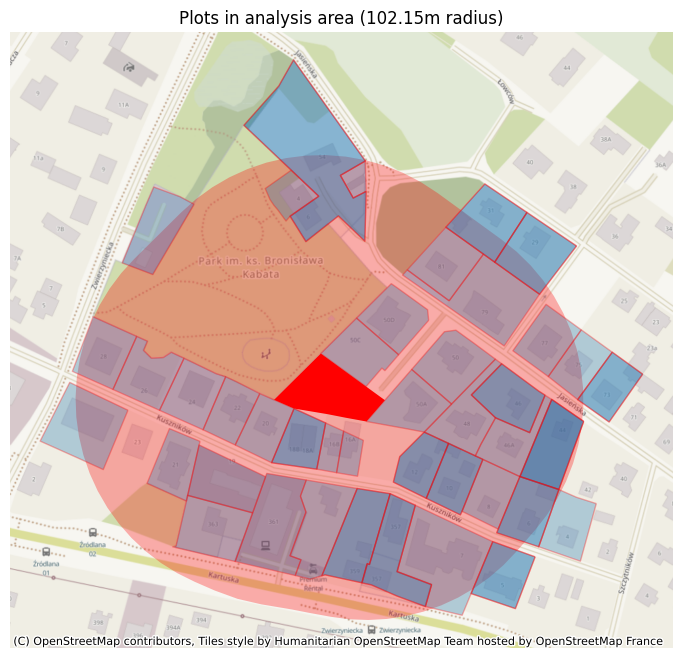

In [338]:
analysis_area = site_geom.buffer(analysis_radius)
print("Number of plots", plots.shape[0])
plots_in_analysis_area = plots[plots.geometry.intersects(analysis_area)]
built_up_plots_in_analysis_area = gpd.sjoin(plots_in_analysis_area, building_centroids, how='inner', predicate='intersects', lsuffix='analysisplot', rsuffix='building')
number_of_built_up_plots_in_analysis_area = built_up_plots_in_analysis_area['gml_id_analysisplot'].nunique()
print("Analysis area has", number_of_built_up_plots_in_analysis_area, "built-up plots")


# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
site.plot(ax=ax, color='red', label='Site')
gpd.GeoSeries(analysis_area).plot(ax=ax, color='red', alpha=0.3, label='Analysis Area')
built_up_plots_in_analysis_area.plot(ax=ax, edgecolor='red', alpha=0.3, label='Analysis Plots')
ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.title(f"Plots in analysis area ({analysis_radius:.2f}m radius)")
plt.show()

In [336]:
# Calculate coverage ratios
coverage_ratios = []
for plot_id in built_up_plots_in_analysis_area['gml_id_analysisplot'].unique():
    # Get the plot
    plot = built_up_plots_in_analysis_area[built_up_plots_in_analysis_area['gml_id_analysisplot'] == plot_id]
    plot_area = plot.geometry.iloc[0].area
    
    # Get all buildings on this plot
    plot_buildings = buildings[buildings['gml_id'].isin(
        built_up_plots_in_analysis_area[
            built_up_plots_in_analysis_area['gml_id_analysisplot'] == plot_id
        ]['gml_id_building']
    )]
    # Calculate total building footprint
    building_area = plot_buildings.geometry.area.sum()
    
    # Calculate coverage ratio
    coverage_ratio = building_area / plot_area
    
    coverage_ratios.append({
        'plot_id': plot_id,
        'plot_area': plot_area,
        'building_area': building_area,
        'coverage_ratio': coverage_ratio
    })

# Convert to DataFrame for analysis
coverage_df = pd.DataFrame(coverage_ratios)

# Print statistics
print("\nBuilding Site Coverage Statistics:")
print(f"Number of built-up plots: {len(coverage_ratios)}")
print(f"Mean coverage ratio: {float(coverage_df['coverage_ratio'].mean()):.2f}")
print(f"Median coverage ratio: {float(coverage_df['coverage_ratio'].median()):.2f}")
print(f"Min coverage ratio: {float(coverage_df['coverage_ratio'].min()):.2f}")
print(f"Max coverage ratio: {float(coverage_df['coverage_ratio'].max()):.2f}")

# Zoning conditions coverage ratio from min to mean+20%
zoning_coverage_ratio_min = float(coverage_df['coverage_ratio'].min())
zoning_coverage_ratio_max = float(coverage_df['coverage_ratio'].mean() * 1.2)



Building Site Coverage Statistics:
Number of built-up plots: 42
Mean coverage ratio: 0.23
Median coverage ratio: 0.22
Min coverage ratio: 0.04
Max coverage ratio: 0.66


/var/folders/j5/0qh0dgj5607fhs9231nrxjww0000gn/T/ipykernel_44894/1396706853.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/j5/0qh0dgj5607fhs9231nrxjww0000gn/T/ipykernel_44894/1396706853.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


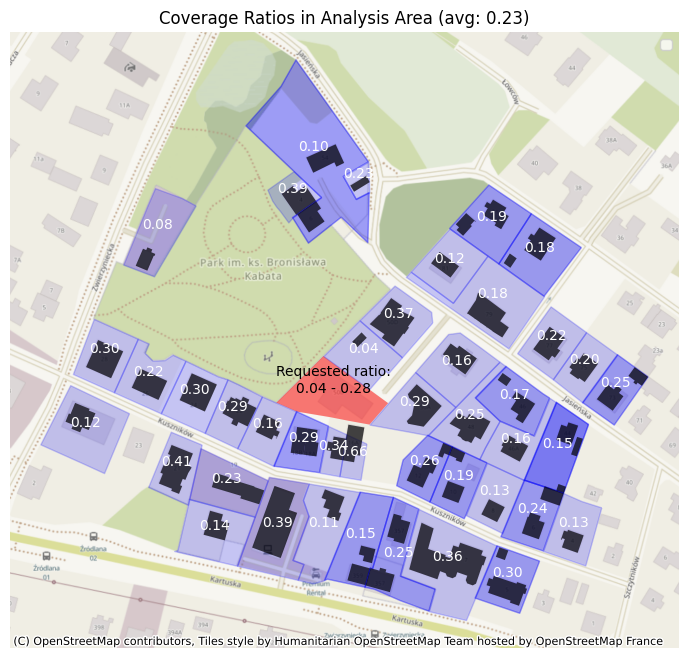

In [340]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot base layers
site.plot(ax=ax, color='red', alpha=0.5, label='Site')

# Plot built-up plots with color based on coverage ratio
for _, ratio_info in coverage_df.iterrows():
    plot = built_up_plots_in_analysis_area[built_up_plots_in_analysis_area['gml_id_analysisplot'] == ratio_info['plot_id']]
    plot_buildings = buildings[buildings['gml_id'].isin(
        built_up_plots_in_analysis_area[
            built_up_plots_in_analysis_area['gml_id_analysisplot'] == ratio_info['plot_id']
        ]['gml_id_building']
    )]
    
    # Plot the plot and its buildings
    plot.plot(ax=ax, color='blue', edgecolor='blue', alpha=0.2)
    plot_buildings.plot(ax=ax, color='black', alpha=0.7)
    
    # Add coverage ratio annotation
    centroid = plot.geometry.iloc[0].centroid
    ax.annotate(f"{ratio_info['coverage_ratio']:.2f}", 
                xy=(centroid.x, centroid.y),
                xytext=(0, 0), textcoords='offset points',
                ha='center', va='bottom', color='white')

# Plot zoning coverage ratios on site centroid
site_centroid = site.geometry.union_all().centroid
ax.annotate(f"Requested ratio:\n{zoning_coverage_ratio_min:.2f} - {zoning_coverage_ratio_max:.2f}", 
            xy=(site_centroid.x, site_centroid.y), 
            ha='center', va='bottom', color='black')

ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.title(f'Coverage Ratios in Analysis Area (avg: {(coverage_df['coverage_ratio'].mean()):.2f})')
plt.legend()
plt.show()